In [33]:
from qwak.qwak import QWAK
import networkx as nx
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from math import sqrt, ceil, pow
import scipy.special as sp
from scipy.linalg import expm
import sympy as simp

In [80]:
def inf_line_bessel_oriented10(k,nx,t,alpha,theta,gamma,l):
    domain = np.arange(0, nx) - nx//2
    prob = np.zeros([nx + 1,1], dtype='complex')
    for x in range(nx):
        prob[x,0] = ( (np.cos(theta)**2) * (sp.jv(domain[x] + k, 2*t)**2)
                     + (np.sin(theta)**2) * (sp.jv(domain[x] - k, 2*t)**2)
                     + 2*((-1)**k)*np.cos(2*alpha*k + gamma)*np.cos(theta)*np.sin(theta)*sp.jv(domain[x] + k, 2*t)*sp.jv(domain[x] - k, 2*t))

    return prob

def getMultipleProbs(k,n,theta,l,gamma,alphaList,timeList):
    timeListList = [timeList]*len(alphaList)
    probListAux = []
    probList = []

    for alpha in alphaList:
        for t in timeList:
            psi_oriented = inf_line_bessel_oriented10(k,n,t,alpha,theta,gamma,l)
            probListAux.append(np.sum(psi_oriented[n//2-k-1:n//2+k+2]))
        probList.append(probListAux)
        probListAux = []

    return probList

def getWeightedGraph(graph,weight):
    auxGraph = graph.reverse()
    for u,v,d in graph.edges(data=True):
        d["weight"] = weight
        mat = np.matrix(d["weight"])
    for u,v,d in auxGraph.edges(data=True):
        d["weight"] = np.conj(weight)
        mat = np.matrix(d["weight"])
    return nx.compose(graph,auxGraph)



In [81]:
n=100
alpha=np.pi/2
weight = np.exp(1j*alpha)

graph = getWeightedGraph(nx.path_graph(n,create_using=nx.DiGraph),weight)
print(graph)

DiGraph with 100 nodes and 198 edges


In [82]:
k = 1
if k > 0:
    theta=np.pi/4
else:
    theta = np.pi/2
l = 0
gamma = l * np.pi


In [83]:
t = 10
initCond = [(n//2-k,(np.cos(theta))),(n//2+k,(np.exp(1j*gamma)*np.sin(theta)))]

qw = QWAK(graph)
qw.runWalk(t,customStateList=initCond)


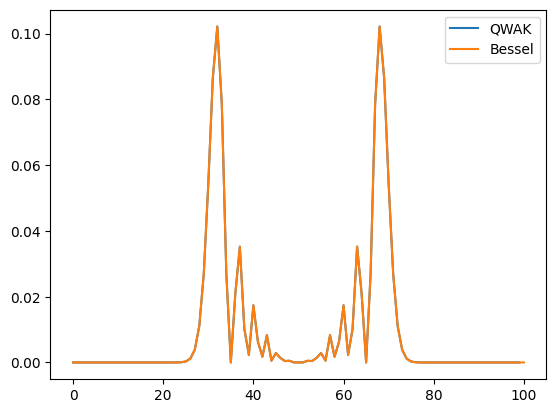

In [84]:
qwakProbDist = qw.getProbVec()
besselProbDist = inf_line_bessel_oriented10(k,100,t,alpha,theta,gamma,l)
plt.plot(qwakProbDist,label="QWAK")
plt.plot(besselProbDist,label='Bessel')
plt.legend()

In [85]:
survProb = qw.getSurvivalProb(n//2-k,n//2+k)
print(survProb)

4.466666487104558e-05


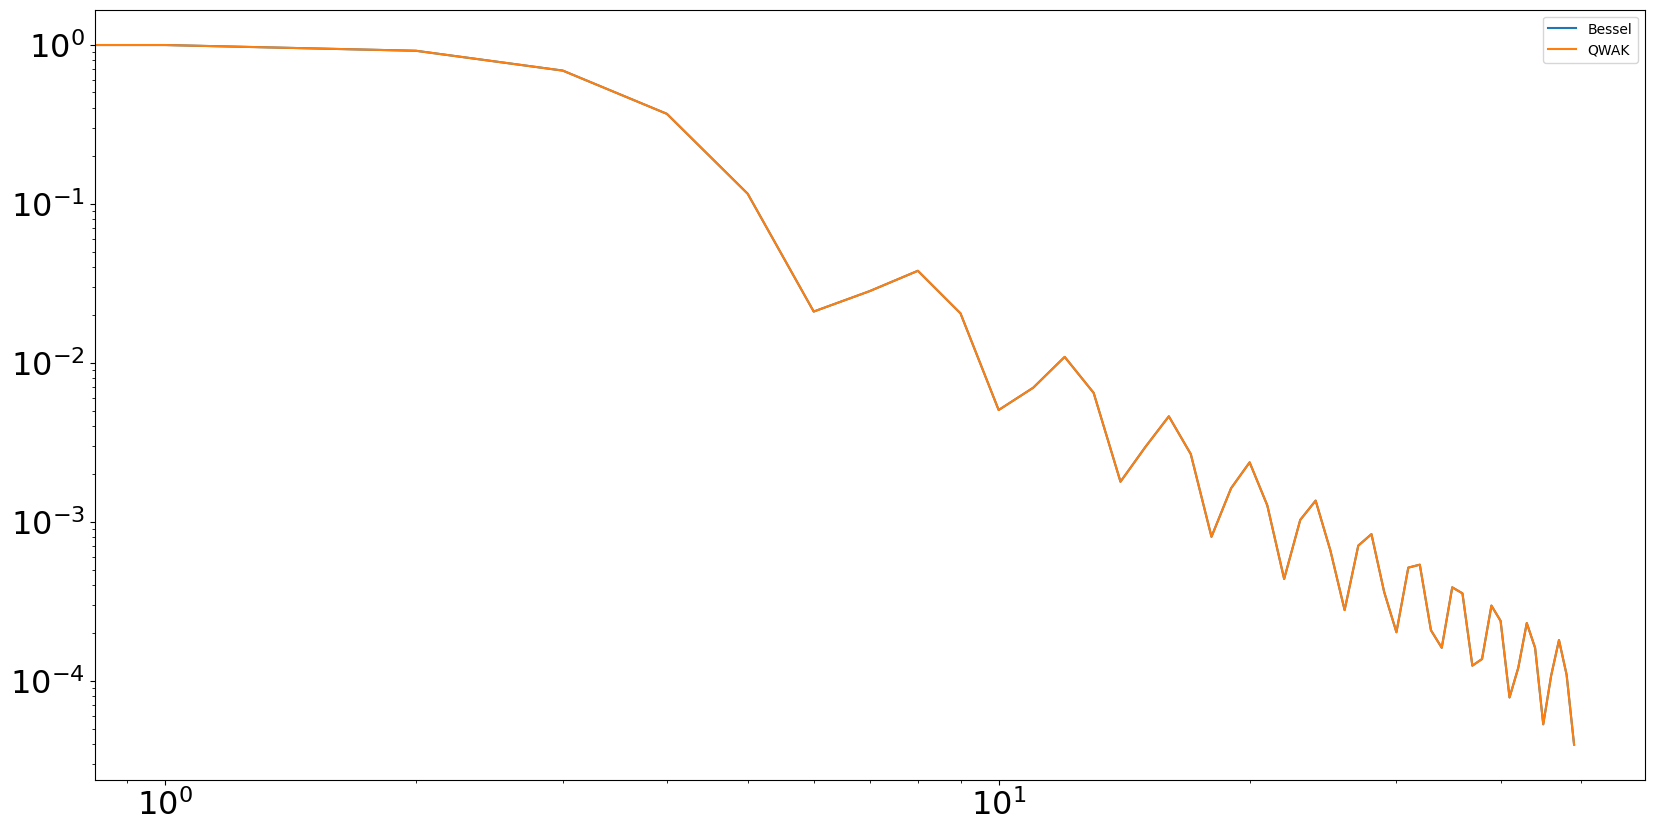

In [89]:
timeList = np.linspace(0,20,50)
qw.runMultipleWalks(timeList)

probDistList = qw.getProbDistList()
survProbList = qw.getSurvivalProbList(n//2-k-1,n//2+k+1)

survProbList2 = getMultipleProbs(k,n,theta,l,gamma,[alpha],timeList)

plt.loglog()
plt.plot(survProbList2[0],label="Bessel")
plt.plot(survProbList,label="QWAK")
plt.legend()